### Предобработка данных. 

В данной работе я решал задачу бинарной классификации изображений по признаку наличия сигарет на них. Прежде всего я собрал датасет с изображениями. Эта деталь решения находится в файле под названием data_maker.py и влючает в себя парсинг сайта, разметку полученных объектов и сохранение информации о них в файл под названием cigarette_classification.csv

Ниже представлены библиотеки, которые я использовал в своём решении. Я пользовался фреймворком PyTorch, обучал модель, основанную на свёрточных нейронный сетях из семейства ResNet. Инструментом для обработки датасета стала библиотека pandas.

In [142]:
import numpy as np
import pandas as pd
import torchvision.models as models
import torch.nn as nn 
import torchvision.transforms as transforms
import torch
from tqdm import tqdm
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader


### Обработка данных

В csv-файле содержится следующая информация об изображениях - метка, указывающая на наличие сигареты на нём (cigarettes если есть, и humans в противоположном случае) и путь до соответствующего изображения.  

In [22]:
data = pd.read_csv('cigarette_classification.csv')
data = data.sample(frac=1).reset_index(drop=True)
data

,picture,link
0,humans,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
1,cigarettes,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
2,humans,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
3,humans,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
4,cigarettes,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
...,...,...
1195,cigarettes,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
1196,humans,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
1197,humans,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
1198,cigarettes,C:\Users\Даниил\Downloads\Homework\Cigarettes\...


Переходим к более естественным числовым меткам - 1 и 0.

In [23]:
data['label'] = data['picture'].apply(lambda x: 1 if x == "cigarettes" else 0)
data = data[['label', 'link']]
data

,label,link
0,0,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
1,1,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
2,0,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
3,0,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
4,1,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
...,...,...
1195,1,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
1196,0,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
1197,0,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
1198,1,C:\Users\Даниил\Downloads\Homework\Cigarettes\...


Разбиваем наши данные на три выборки - тренировочную, валидационную и тестовую. 


In [110]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size=0.25)
val_data, test_data = train_test_split(val_data, test_size=0.25)
test_data

,label,link
835,0,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
623,1,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
370,1,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
613,1,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
1115,1,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
...,...,...
227,1,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
785,0,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
1029,1,C:\Users\Даниил\Downloads\Homework\Cigarettes\...
120,0,C:\Users\Даниил\Downloads\Homework\Cigarettes\...


### Первая модель

Как я уже сказал, для обучения модели использовались архитектуры сверточной нейронной сети под названием ResNet. Я использовал модель с 18-ю обучающими слоями.

In [143]:
model = models.resnet18()
num_of_classes = 2

model.fc = nn.Linear(model.fc.in_features, num_of_classes)

Определяем трансформации

In [111]:
transform_train = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
transform_val = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
transform_test = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

Транслируем изображения в нужный нам формат

In [112]:
def to_images(transform, data):
    return [(transform(Image.open(row['link']).convert("RGB")), row['label']) for _, row in data.iterrows()]

test_images = to_images(transform_test, test_data)
val_images = to_images(transform_val, val_data)
train_images = to_images(transform_train, train_data)

C:\Users\Даниил\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:3176: DecompressionBombWarning: Image size (142643260 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [113]:
test_images[0]
val_images[0]
train_images[0]

(tensor([[[0.2118, 0.2196, 0.2196,  ..., 0.3647, 0.3647, 0.3529],
          [0.2157, 0.2275, 0.2431,  ..., 0.3451, 0.3451, 0.3333],
          [0.2588, 0.2784, 0.2941,  ..., 0.3451, 0.3451, 0.3294],
          ...,
          [0.2078, 0.1529, 0.0745,  ..., 0.4353, 0.4235, 0.4039],
          [0.1176, 0.0784, 0.0275,  ..., 0.4627, 0.4392, 0.4196],
          [0.0745, 0.0471, 0.0196,  ..., 0.4667, 0.4471, 0.4314]],
 
         [[0.2667, 0.2627, 0.2667,  ..., 0.4039, 0.4039, 0.3922],
          [0.2667, 0.2745, 0.2941,  ..., 0.3843, 0.3843, 0.3686],
          [0.3098, 0.3294, 0.3490,  ..., 0.3804, 0.3804, 0.3647],
          ...,
          [0.2039, 0.1529, 0.0902,  ..., 0.4510, 0.4235, 0.3961],
          [0.1294, 0.0941, 0.0627,  ..., 0.4471, 0.4157, 0.3922],
          [0.0980, 0.0784, 0.0627,  ..., 0.4392, 0.4157, 0.3922]],
 
         [[0.1216, 0.1176, 0.1098,  ..., 0.2000, 0.1961, 0.1843],
          [0.1176, 0.1137, 0.1216,  ..., 0.1843, 0.1843, 0.1804],
          [0.1255, 0.1333, 0.1373,  ...,

И разбиваем их на батчи. 

In [114]:
batch_size = 64
test_loader = DataLoader(test_images, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_images, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_images, batch_size=batch_size, shuffle=True)

Валидация модели до обучения. 

In [115]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
model.to(device)
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

precision = precision_score(all_labels, all_predictions, average='binary')
recall = recall_score(all_labels, all_predictions, average='binary')
f1 = f1_score(all_labels, all_predictions, average='binary')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

100%|██████████| 4/4 [00:21<00:00,  5.35s/it]

Precision: 1.0000
Recall: 0.0098
F1 Score: 0.0194


Я собрал одинаковое количество изображений с сигаретами и без, однако в построенных выборках их соотношение могло немного измениться. Посмотрим, в каком соотношении находятся классы для каждой выборки. 

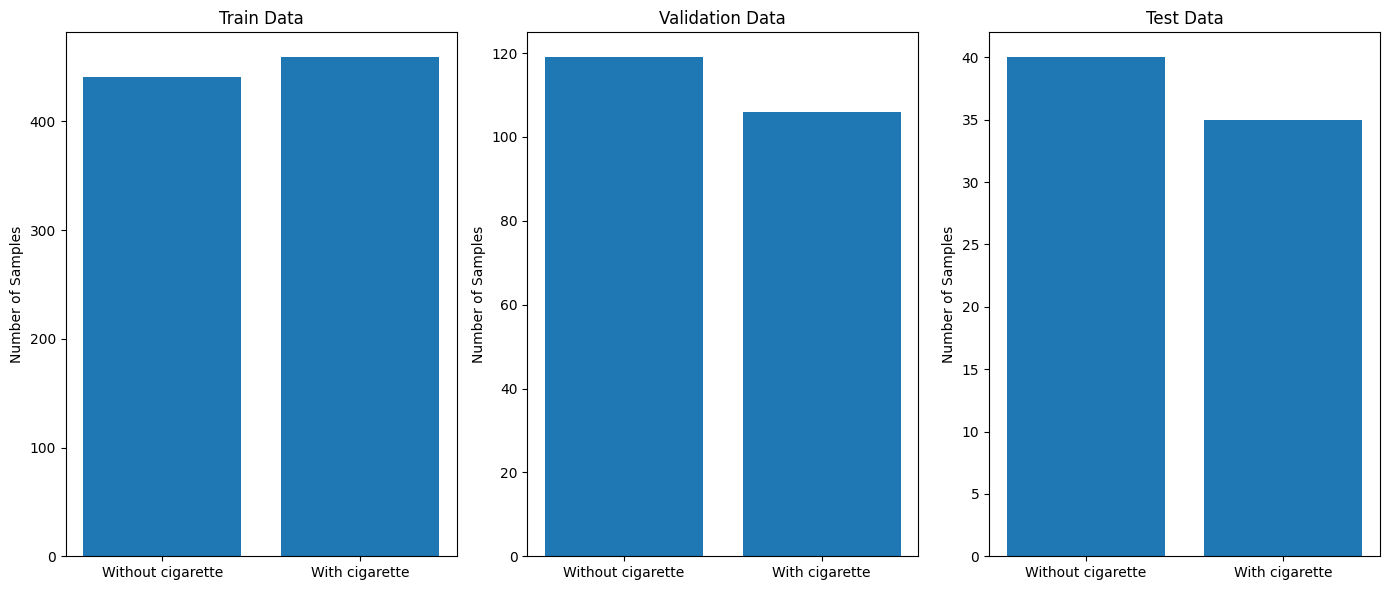

In [63]:

train_class_counts = np.zeros(num_of_classes)
val_class_counts = np.zeros(num_of_classes)
test_class_counts = np.zeros(num_of_classes)
for _, label in train_images: 
    train_class_counts[label] += 1
for _, label in val_images: 
    val_class_counts[label] += 1  
for _, label in test_images: 
    test_class_counts[label] += 1
class_names = ["Without cigarette", "With cigarette"]

fig, axs = plt.subplots(1, 3, figsize=(14, 6))

axs[0].bar(class_names, train_class_counts)
axs[0].set_ylabel('Number of Samples')
axs[0].set_title('Train Data')
axs[1].bar(class_names, val_class_counts)
axs[1].set_ylabel('Number of Samples')
axs[1].set_title('Validation Data')
axs[2].bar(class_names, test_class_counts)
axs[2].set_ylabel('Number of Samples')
axs[2].set_title('Test Data')
plt.tight_layout()
plt.show()


Ожидаемо, они разбились примерно поровну в каждую выборку.

Перейдём к гиперпараметрам нашей модели. В качестве функции потерь будет использоваться кросс-энтропия. Оптимизатор - Адам. Метрикой оценки качества будет F1-мера, позволяющая учитывать одновременно и recall, и precision. Количество эпох я взял равное 30. Размер одного батча был задан выше, и равен он 64

In [116]:
best_f1_score = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
best_f1_score = 0
model.to(device)
num_epochs = 30

### Обучение сети. 

In [117]:
train_losses, val_losses = [], []
train_recalls, train_precisions = [], []
val_recalls, val_precisions = [], []

best_f1_score = 0.0  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_train_labels = []
    all_train_predictions = []

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)  
        all_train_labels.extend(labels.cpu().numpy())
        all_train_predictions.extend(predicted.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    train_precision = precision_score(all_train_labels, all_train_predictions, average='binary', zero_division=0)
    train_recall = recall_score(all_train_labels, all_train_predictions, average='binary', zero_division=0)
    train_f1 = f1_score(all_train_labels, all_train_predictions, average='binary', zero_division=0)

    train_precisions.append(train_precision)
    train_recalls.append(train_recall)

    model.eval()
    val_loss = 0.0
    all_val_labels = []
    all_val_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = outputs.max(1)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_predictions.extend(predicted.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_precision = precision_score(all_val_labels, all_val_predictions, average='binary', zero_division=0)
    val_recall = recall_score(all_val_labels, all_val_predictions, average='binary', zero_division=0)
    val_f1 = f1_score(all_val_labels, all_val_predictions, average='binary', zero_division=0)

    val_precisions.append(val_precision)
    val_recalls.append(val_recall)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Recall: {train_recall:.4f}, Train Precision: {train_precision:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Recall: {val_recall:.4f}, Val Precision: {val_precision:.4f}, Val F1 Score: {val_f1:.4f}')

    if val_f1 > best_f1_score:
        best_f1_score = val_f1
        torch.save(model.state_dict(), 'best_model.pth')
        print('Saved best model!')

torch.save(model.state_dict(), 'last_model.pth')
print()

100%|██████████| 4/4 [00:14<00:00,  3.72s/it]


Epoch [1/30], Train Loss: 0.6922, Train Recall: 0.7181, Train Precision: 0.5199, Val Loss: 0.6993, Val Recall: 0.9804, Val Precision: 0.4484, Val F1 Score: 0.6154
Saved best model!


100%|██████████| 4/4 [00:15<00:00,  3.76s/it]


Epoch [2/30], Train Loss: 0.6771, Train Recall: 0.7225, Train Precision: 0.5607, Val Loss: 0.7168, Val Recall: 1.0000, Val Precision: 0.4533, Val F1 Score: 0.6239
Saved best model!


100%|██████████| 4/4 [00:24<00:00,  6.05s/it]


Epoch [3/30], Train Loss: 0.6670, Train Recall: 0.7026, Train Precision: 0.5842, Val Loss: 0.7195, Val Recall: 0.9902, Val Precision: 0.4509, Val F1 Score: 0.6196


100%|██████████| 4/4 [00:15<00:00,  3.82s/it]


Epoch [4/30], Train Loss: 0.6568, Train Recall: 0.6762, Train Precision: 0.5961, Val Loss: 0.6987, Val Recall: 0.9020, Val Precision: 0.4600, Val F1 Score: 0.6093


100%|██████████| 4/4 [00:23<00:00,  5.79s/it]


Epoch [5/30], Train Loss: 0.6650, Train Recall: 0.6872, Train Precision: 0.6130, Val Loss: 0.6854, Val Recall: 0.7451, Val Precision: 0.5101, Val F1 Score: 0.6056


100%|██████████| 4/4 [00:19<00:00,  4.81s/it]


Epoch [6/30], Train Loss: 0.6627, Train Recall: 0.6740, Train Precision: 0.6083, Val Loss: 0.6801, Val Recall: 0.7157, Val Precision: 0.5530, Val F1 Score: 0.6239
Saved best model!


100%|██████████| 4/4 [00:25<00:00,  6.27s/it]


Epoch [7/30], Train Loss: 0.6562, Train Recall: 0.6828, Train Precision: 0.6175, Val Loss: 0.6790, Val Recall: 0.7255, Val Precision: 0.5522, Val F1 Score: 0.6271
Saved best model!


100%|██████████| 4/4 [00:22<00:00,  5.63s/it]


Epoch [8/30], Train Loss: 0.6555, Train Recall: 0.6806, Train Precision: 0.6319, Val Loss: 0.6736, Val Recall: 0.6765, Val Precision: 0.5520, Val F1 Score: 0.6079


100%|██████████| 4/4 [00:23<00:00,  5.75s/it]


Epoch [9/30], Train Loss: 0.6573, Train Recall: 0.6762, Train Precision: 0.6278, Val Loss: 0.6762, Val Recall: 0.7157, Val Precision: 0.5573, Val F1 Score: 0.6266


100%|██████████| 4/4 [00:14<00:00,  3.69s/it]


Epoch [10/30], Train Loss: 0.6469, Train Recall: 0.6740, Train Precision: 0.6429, Val Loss: 0.6715, Val Recall: 0.6765, Val Precision: 0.5565, Val F1 Score: 0.6106


100%|██████████| 4/4 [00:14<00:00,  3.65s/it]


Epoch [11/30], Train Loss: 0.6433, Train Recall: 0.6740, Train Precision: 0.6349, Val Loss: 0.6664, Val Recall: 0.6078, Val Precision: 0.5794, Val F1 Score: 0.5933


100%|██████████| 4/4 [00:15<00:00,  3.81s/it]


Epoch [12/30], Train Loss: 0.6377, Train Recall: 0.6762, Train Precision: 0.6436, Val Loss: 0.6686, Val Recall: 0.6471, Val Precision: 0.5789, Val F1 Score: 0.6111


100%|██████████| 4/4 [00:15<00:00,  3.85s/it]


Epoch [13/30], Train Loss: 0.6457, Train Recall: 0.6674, Train Precision: 0.6474, Val Loss: 0.6672, Val Recall: 0.6471, Val Precision: 0.5841, Val F1 Score: 0.6140


100%|██████████| 4/4 [00:14<00:00,  3.69s/it]


Epoch [14/30], Train Loss: 0.6346, Train Recall: 0.6740, Train Precision: 0.6511, Val Loss: 0.6670, Val Recall: 0.6863, Val Precision: 0.5882, Val F1 Score: 0.6335
Saved best model!


100%|██████████| 4/4 [00:14<00:00,  3.59s/it]


Epoch [15/30], Train Loss: 0.6417, Train Recall: 0.6564, Train Precision: 0.6622, Val Loss: 0.6664, Val Recall: 0.6961, Val Precision: 0.5868, Val F1 Score: 0.6368
Saved best model!


100%|██████████| 4/4 [00:14<00:00,  3.61s/it]


Epoch [16/30], Train Loss: 0.6409, Train Recall: 0.6344, Train Precision: 0.6636, Val Loss: 0.6643, Val Recall: 0.6569, Val Precision: 0.5826, Val F1 Score: 0.6175


100%|██████████| 4/4 [00:14<00:00,  3.67s/it]


Epoch [17/30], Train Loss: 0.6211, Train Recall: 0.6740, Train Precision: 0.6623, Val Loss: 0.6602, Val Recall: 0.6176, Val Precision: 0.5943, Val F1 Score: 0.6058


100%|██████████| 4/4 [00:14<00:00,  3.72s/it]


Epoch [18/30], Train Loss: 0.6207, Train Recall: 0.6718, Train Precision: 0.6793, Val Loss: 0.6582, Val Recall: 0.5980, Val Precision: 0.6224, Val F1 Score: 0.6100


100%|██████████| 4/4 [00:15<00:00,  3.78s/it]


Epoch [19/30], Train Loss: 0.6321, Train Recall: 0.6564, Train Precision: 0.6667, Val Loss: 0.6598, Val Recall: 0.6275, Val Precision: 0.5766, Val F1 Score: 0.6009


100%|██████████| 4/4 [00:15<00:00,  3.86s/it]


Epoch [20/30], Train Loss: 0.6212, Train Recall: 0.6674, Train Precision: 0.6982, Val Loss: 0.6583, Val Recall: 0.6471, Val Precision: 0.5841, Val F1 Score: 0.6140


100%|██████████| 4/4 [00:14<00:00,  3.71s/it]


Epoch [21/30], Train Loss: 0.6214, Train Recall: 0.6586, Train Precision: 0.6811, Val Loss: 0.6547, Val Recall: 0.6176, Val Precision: 0.6300, Val F1 Score: 0.6238


100%|██████████| 4/4 [00:14<00:00,  3.59s/it]


Epoch [22/30], Train Loss: 0.6257, Train Recall: 0.6476, Train Precision: 0.6759, Val Loss: 0.6560, Val Recall: 0.6471, Val Precision: 0.6226, Val F1 Score: 0.6346


100%|██████████| 4/4 [00:14<00:00,  3.63s/it]


Epoch [23/30], Train Loss: 0.6253, Train Recall: 0.6696, Train Precision: 0.7021, Val Loss: 0.6569, Val Recall: 0.6667, Val Precision: 0.6018, Val F1 Score: 0.6326


100%|██████████| 4/4 [00:15<00:00,  3.76s/it]


Epoch [24/30], Train Loss: 0.6088, Train Recall: 0.6564, Train Precision: 0.7215, Val Loss: 0.6556, Val Recall: 0.6863, Val Precision: 0.6034, Val F1 Score: 0.6422
Saved best model!


100%|██████████| 4/4 [00:14<00:00,  3.60s/it]


Epoch [25/30], Train Loss: 0.6140, Train Recall: 0.6762, Train Precision: 0.7074, Val Loss: 0.6515, Val Recall: 0.6471, Val Precision: 0.6168, Val F1 Score: 0.6316


100%|██████████| 4/4 [00:14<00:00,  3.71s/it]


Epoch [26/30], Train Loss: 0.6059, Train Recall: 0.6674, Train Precision: 0.7146, Val Loss: 0.6510, Val Recall: 0.6373, Val Precision: 0.6190, Val F1 Score: 0.6280


100%|██████████| 4/4 [00:14<00:00,  3.60s/it]


Epoch [27/30], Train Loss: 0.6210, Train Recall: 0.6630, Train Precision: 0.7033, Val Loss: 0.6519, Val Recall: 0.6275, Val Precision: 0.6214, Val F1 Score: 0.6244


100%|██████████| 4/4 [00:14<00:00,  3.62s/it]


Epoch [28/30], Train Loss: 0.6166, Train Recall: 0.6432, Train Precision: 0.7105, Val Loss: 0.6499, Val Recall: 0.6275, Val Precision: 0.6214, Val F1 Score: 0.6244


100%|██████████| 4/4 [00:14<00:00,  3.71s/it]


Epoch [29/30], Train Loss: 0.6081, Train Recall: 0.6630, Train Precision: 0.7236, Val Loss: 0.6532, Val Recall: 0.6765, Val Precision: 0.6000, Val F1 Score: 0.6359


100%|██████████| 4/4 [00:14<00:00,  3.70s/it]

Epoch [30/30], Train Loss: 0.6150, Train Recall: 0.6608, Train Precision: 0.7143, Val Loss: 0.6495, Val Recall: 0.6569, Val Precision: 0.6262, Val F1 Score: 0.6411


Визуализируем полученный результат:

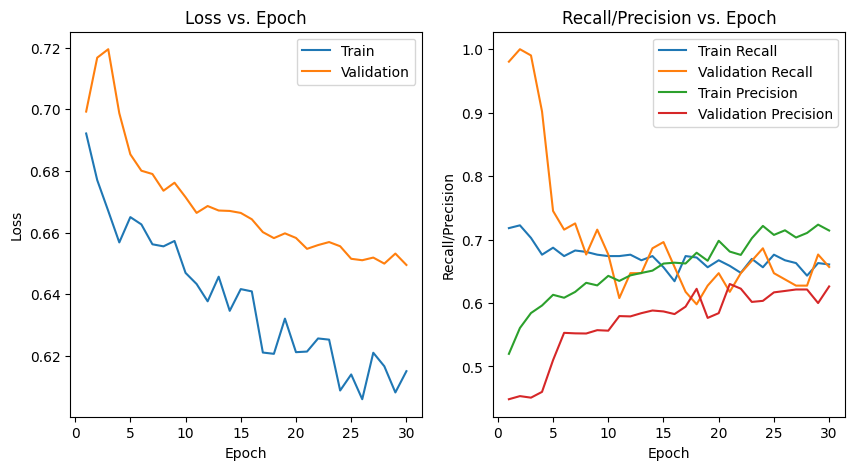

In [118]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_recalls, label='Train Recall')
plt.plot(range(1, num_epochs+1), val_recalls, label='Validation Recall')
plt.plot(range(1, num_epochs+1), train_precisions, label='Train Precision')
plt.plot(range(1, num_epochs+1), val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Recall/Precision')
plt.title('Recall/Precision vs. Epoch')
plt.legend()

plt.show()

Видно, что модель продолжала обучаться на протяжении всех 30 эпох. Возможно, я бы смог улучшить результат, если бы задал этот параметр большим значением. Наилучшее значение F1 меры достигается где-то после 20 эпох. Скорее всего, я собрал довольно тяжелый для обучения датасет, так как помимо сигарет в нём также присутствует множество других объектов, и из-за этого не смог достичь впечатляющих результатов на простой модели. Тем не менее, результат значительно лучше бейслайна, а значит чему-то обучить её, да удалось. 

### Модель с добавлением аугментаций

Попробуем добавить в нашу модель устойчивость к поворотам и отображениям. Изначально я взял ResNet50 в качестве архитектуры этой модели, но результаты оставляли желать лучшего, а сама модель слишком долго обучалась. Поэтому было принято решение в этом пункте также использовать ResNet18. Проделываем практически всё то же самое, что и ранее:


In [145]:
model_a = models.resnet18(weights=True)
model_a.fc = nn.Linear(model_a.fc.in_features, num_of_classes)

C:\Users\Даниил\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [132]:
def transform_a():
    return transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(10),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

transform_train_a = transform_a()
transform_val_a = transform_a()
transform_test_a = transform_a()

In [133]:
test_images_a = to_images(transform_test_a, test_data)
val_images_a = to_images(transform_val_a, val_data)
train_images_a = to_images(transform_train_a, train_data)

C:\Users\Даниил\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:3176: DecompressionBombWarning: Image size (142643260 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [134]:
test_loader_a = DataLoader(test_images_a, batch_size=batch_size, shuffle=False)
val_loader_a = DataLoader(val_images_a, batch_size=batch_size, shuffle=False)
train_loader_a = DataLoader(train_images_a, batch_size=batch_size, shuffle=True)

In [135]:
model_a.eval()
model_a.to(device)
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in tqdm(val_loader_a):
        images, labels = images.to(device), labels.to(device)
        outputs = model_a(images)
        _, predicted = outputs.max(1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

precision = precision_score(all_labels, all_predictions, average='binary')
recall = recall_score(all_labels, all_predictions, average='binary')
f1 = f1_score(all_labels, all_predictions, average='binary')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

100%|██████████| 4/4 [00:25<00:00,  6.44s/it]

Precision: 0.5833
Recall: 0.3431
F1 Score: 0.4321


### Обучение

In [136]:
train_losses_a, val_losses_a = [], []
train_recalls_a, train_precisions_a = [], []
val_recalls_a, val_precisions_a = [], []
num_epochs = 30
for epoch in range(num_epochs):
    model_a.train()
    running_loss = 0.0
    all_train_labels = []
    all_train_predictions = []

    for images, labels in tqdm(train_loader_a):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_a(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_predictions.extend(predicted.cpu().numpy())

    train_loss = running_loss / len(train_loader_a)
    train_losses_a.append(train_loss)

    train_precision = precision_score(all_train_labels, all_train_predictions, average='binary', zero_division=0)
    train_recall = recall_score(all_train_labels, all_train_predictions, average='binary', zero_division=0)
    train_f1 = f1_score(all_train_labels, all_train_predictions, average='binary', zero_division=0)
    
    train_precisions_a.append(train_precision)
    train_recalls_a.append(train_recall)
    
    model_a.eval()
    val_loss = 0.0
    all_val_labels = []
    all_val_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader_a):
            images, labels = images.to(device), labels.to(device)
            outputs = model_a(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = outputs.max(1)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_predictions.extend(predicted.cpu().numpy())

    val_loss /= len(val_loader_a)
    val_losses_a.append(val_loss)

    val_precision = precision_score(all_val_labels, all_val_predictions, average='binary',  zero_division=0)
    val_recall = recall_score(all_val_labels, all_val_predictions, average='binary',  zero_division=0)
    val_f1 = f1_score(all_val_labels, all_val_predictions, average='binary',  zero_division=0)
    val_precisions_a.append(val_precision)
    val_recalls_a.append(val_recall)
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Recall: {train_recall:.4f}, Train Precision: {train_precision:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Recall: {val_recall:.4f}, Val Precision: {val_precision:.4f}, Val F1 Score: {val_f1:.4f}')

    if val_f1 > best_f1_score:
        best_f1_score = val_f1
        torch.save(model_a.state_dict(), 'best_model.pth')
        print('Saved best model!')

torch.save(model.state_dict(), 'last_model.pth')
print()

100%|██████████| 4/4 [00:15<00:00,  3.82s/it]


Epoch [1/30], Train Loss: 0.7443, Train Recall: 0.1806, Train Precision: 0.6891, Val Loss: 0.6698, Val Recall: 0.2157, Val Precision: 0.5946, Val F1 Score: 0.3165


100%|██████████| 4/4 [00:16<00:00,  4.20s/it]


Epoch [2/30], Train Loss: 0.7128, Train Recall: 0.1784, Train Precision: 0.7105, Val Loss: 0.6743, Val Recall: 0.2255, Val Precision: 0.6053, Val F1 Score: 0.3286


100%|██████████| 4/4 [00:15<00:00,  3.80s/it]


Epoch [3/30], Train Loss: 0.7271, Train Recall: 0.1784, Train Precision: 0.6639, Val Loss: 0.6859, Val Recall: 0.1765, Val Precision: 0.5143, Val F1 Score: 0.2628


100%|██████████| 4/4 [00:16<00:00,  4.14s/it]


Epoch [4/30], Train Loss: 0.7228, Train Recall: 0.1894, Train Precision: 0.6880, Val Loss: 0.6863, Val Recall: 0.1961, Val Precision: 0.5405, Val F1 Score: 0.2878


100%|██████████| 4/4 [00:16<00:00,  4.17s/it]


Epoch [5/30], Train Loss: 0.7433, Train Recall: 0.1828, Train Precision: 0.6640, Val Loss: 0.6885, Val Recall: 0.1863, Val Precision: 0.5429, Val F1 Score: 0.2774


100%|██████████| 4/4 [00:14<00:00,  3.74s/it]


Epoch [6/30], Train Loss: 0.7202, Train Recall: 0.1806, Train Precision: 0.6891, Val Loss: 0.6836, Val Recall: 0.2059, Val Precision: 0.5833, Val F1 Score: 0.3043


100%|██████████| 4/4 [00:14<00:00,  3.69s/it]


Epoch [7/30], Train Loss: 0.7464, Train Recall: 0.1828, Train Precision: 0.6748, Val Loss: 0.6872, Val Recall: 0.1961, Val Precision: 0.5714, Val F1 Score: 0.2920


100%|██████████| 4/4 [00:15<00:00,  3.78s/it]


Epoch [8/30], Train Loss: 0.7269, Train Recall: 0.1806, Train Precision: 0.6949, Val Loss: 0.6971, Val Recall: 0.1569, Val Precision: 0.5161, Val F1 Score: 0.2406


100%|██████████| 4/4 [00:15<00:00,  3.75s/it]


Epoch [9/30], Train Loss: 0.7425, Train Recall: 0.1916, Train Precision: 0.7500, Val Loss: 0.6967, Val Recall: 0.1471, Val Precision: 0.5172, Val F1 Score: 0.2290


100%|██████████| 4/4 [00:15<00:00,  3.81s/it]


Epoch [10/30], Train Loss: 0.7573, Train Recall: 0.1938, Train Precision: 0.6875, Val Loss: 0.6893, Val Recall: 0.1863, Val Precision: 0.5588, Val F1 Score: 0.2794


100%|██████████| 4/4 [00:15<00:00,  3.83s/it]


Epoch [11/30], Train Loss: 0.7337, Train Recall: 0.1718, Train Precision: 0.7091, Val Loss: 0.6915, Val Recall: 0.1667, Val Precision: 0.5312, Val F1 Score: 0.2537


100%|██████████| 4/4 [00:14<00:00,  3.64s/it]


Epoch [12/30], Train Loss: 0.7302, Train Recall: 0.1872, Train Precision: 0.6855, Val Loss: 0.6776, Val Recall: 0.2059, Val Precision: 0.5676, Val F1 Score: 0.3022


100%|██████████| 4/4 [00:14<00:00,  3.67s/it]


Epoch [13/30], Train Loss: 0.7306, Train Recall: 0.1916, Train Precision: 0.7073, Val Loss: 0.6792, Val Recall: 0.1961, Val Precision: 0.5714, Val F1 Score: 0.2920


100%|██████████| 4/4 [00:15<00:00,  3.80s/it]


Epoch [14/30], Train Loss: 0.7257, Train Recall: 0.1806, Train Precision: 0.7009, Val Loss: 0.6798, Val Recall: 0.2059, Val Precision: 0.5833, Val F1 Score: 0.3043


100%|██████████| 4/4 [00:14<00:00,  3.74s/it]


Epoch [15/30], Train Loss: 0.7599, Train Recall: 0.1806, Train Precision: 0.6949, Val Loss: 0.6856, Val Recall: 0.1373, Val Precision: 0.4828, Val F1 Score: 0.2137


100%|██████████| 4/4 [00:15<00:00,  3.78s/it]


Epoch [16/30], Train Loss: 0.7401, Train Recall: 0.1762, Train Precision: 0.6957, Val Loss: 0.6830, Val Recall: 0.1961, Val Precision: 0.5714, Val F1 Score: 0.2920


100%|██████████| 4/4 [00:14<00:00,  3.66s/it]


Epoch [17/30], Train Loss: 0.7236, Train Recall: 0.1762, Train Precision: 0.6723, Val Loss: 0.6787, Val Recall: 0.2059, Val Precision: 0.5676, Val F1 Score: 0.3022


100%|██████████| 4/4 [00:15<00:00,  3.76s/it]


Epoch [18/30], Train Loss: 0.7378, Train Recall: 0.1696, Train Precision: 0.6814, Val Loss: 0.6789, Val Recall: 0.2059, Val Precision: 0.5833, Val F1 Score: 0.3043


100%|██████████| 4/4 [00:14<00:00,  3.51s/it]


Epoch [19/30], Train Loss: 0.7516, Train Recall: 0.1938, Train Precision: 0.7273, Val Loss: 0.6905, Val Recall: 0.1863, Val Precision: 0.5588, Val F1 Score: 0.2794


100%|██████████| 4/4 [00:13<00:00,  3.43s/it]


Epoch [20/30], Train Loss: 0.7128, Train Recall: 0.1806, Train Precision: 0.6891, Val Loss: 0.6782, Val Recall: 0.2059, Val Precision: 0.5833, Val F1 Score: 0.3043


100%|██████████| 4/4 [00:15<00:00,  3.99s/it]


Epoch [21/30], Train Loss: 0.7488, Train Recall: 0.1828, Train Precision: 0.6640, Val Loss: 0.6784, Val Recall: 0.1961, Val Precision: 0.5556, Val F1 Score: 0.2899


100%|██████████| 4/4 [00:17<00:00,  4.29s/it]


Epoch [22/30], Train Loss: 0.7489, Train Recall: 0.1784, Train Precision: 0.6750, Val Loss: 0.6800, Val Recall: 0.1863, Val Precision: 0.5429, Val F1 Score: 0.2774


100%|██████████| 4/4 [00:20<00:00,  5.17s/it]


Epoch [23/30], Train Loss: 0.7330, Train Recall: 0.1806, Train Precision: 0.6949, Val Loss: 0.6786, Val Recall: 0.1961, Val Precision: 0.5714, Val F1 Score: 0.2920


100%|██████████| 4/4 [00:14<00:00,  3.74s/it]


Epoch [24/30], Train Loss: 0.7191, Train Recall: 0.1784, Train Precision: 0.6923, Val Loss: 0.6798, Val Recall: 0.2059, Val Precision: 0.5833, Val F1 Score: 0.3043


100%|██████████| 4/4 [00:15<00:00,  3.86s/it]


Epoch [25/30], Train Loss: 0.7477, Train Recall: 0.1762, Train Precision: 0.6299, Val Loss: 0.6819, Val Recall: 0.1765, Val Precision: 0.5455, Val F1 Score: 0.2667


100%|██████████| 4/4 [00:15<00:00,  3.95s/it]


Epoch [26/30], Train Loss: 0.7290, Train Recall: 0.1916, Train Precision: 0.7016, Val Loss: 0.6847, Val Recall: 0.1961, Val Precision: 0.5714, Val F1 Score: 0.2920


100%|██████████| 4/4 [00:15<00:00,  3.83s/it]


Epoch [27/30], Train Loss: 0.7178, Train Recall: 0.1872, Train Precision: 0.6911, Val Loss: 0.6806, Val Recall: 0.2059, Val Precision: 0.5676, Val F1 Score: 0.3022


100%|██████████| 4/4 [00:14<00:00,  3.65s/it]


Epoch [28/30], Train Loss: 0.7427, Train Recall: 0.1652, Train Precision: 0.6522, Val Loss: 0.6850, Val Recall: 0.1961, Val Precision: 0.5714, Val F1 Score: 0.2920


100%|██████████| 4/4 [00:16<00:00,  4.18s/it]


Epoch [29/30], Train Loss: 0.7275, Train Recall: 0.1894, Train Precision: 0.7049, Val Loss: 0.6837, Val Recall: 0.1961, Val Precision: 0.5714, Val F1 Score: 0.2920


100%|██████████| 4/4 [00:14<00:00,  3.60s/it]


Epoch [30/30], Train Loss: 0.7533, Train Recall: 0.1916, Train Precision: 0.6744, Val Loss: 0.6872, Val Recall: 0.1863, Val Precision: 0.5588, Val F1 Score: 0.2794


Результаты получились ещё менее впечатляющие, за 30 эпох модель практически не сдвинулась с места. Метрика Precision выдавала довольно приемлемые значения, в то время как recall не сдвигалась со значения 0.2. 

С другой стороны, так как мы решаем задачу бинарной классификации, модель, показывающая сильно плохой результат может работать достаточно хорошо при изменении меток классов на противоположные. 

### Тестируем модель на тестовой выборке.

Берём модель, показавшую наилучший результат в процессе обучения.

In [146]:
model = models.resnet18() 
model.fc = nn.Linear(512, 2)  
model.load_state_dict(torch.load('best_model.pth'))  
model.to(device)
model.eval()


C:\Users\Даниил\AppData\Local\Temp\ipykernel_16436\3050495514.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Запускаем на ней тестовые данные.

In [139]:
all_test_labels = []
all_test_predictions = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        all_test_labels.extend(labels.cpu().numpy())
        all_test_predictions.extend(predicted.cpu().numpy())

test_precision = precision_score(all_test_labels, all_test_predictions, average='weighted')
test_recall = recall_score(all_test_labels, all_test_predictions, average='weighted')
test_f1 = f1_score(all_test_labels, all_test_predictions, average='weighted')
test_accuracy = accuracy_score(all_test_labels, all_test_predictions)
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

100%|██████████| 2/2 [00:06<00:00,  3.50s/it]

Test Precision: 0.6137
Test Recall: 0.6000
Test F1 Score: 0.6030


Результаты уступают тому, что выдавала модель на тренировочных и валидационных данных. Однако, это всё ещё лучше чем бейслайн. Лучшего результата можно было бы достигнуть обучением на большем числе эпох, а также увеличением датасета, либо более качественным его сбором. Возможно стоило использовать какие-то более сложные модели в процессе обучения, но мощность моего компьютера плохо позволяла мне это сделать. 

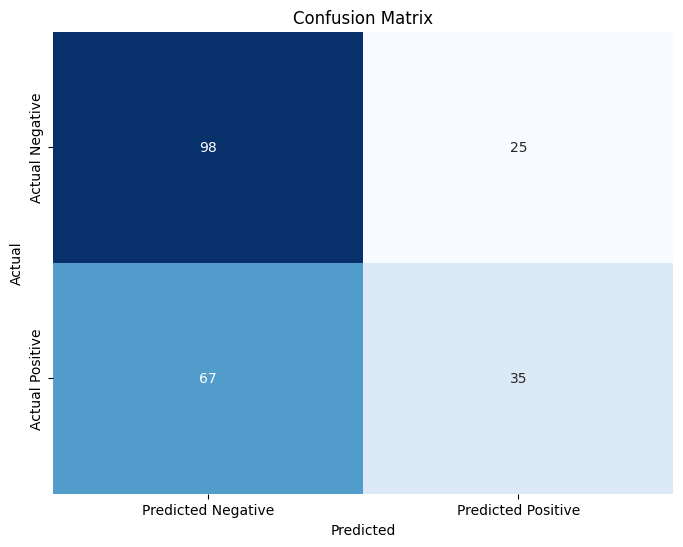

In [140]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_predictions) 

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()